#### 본 매뉴얼에서는 상태공간모형(State-space model) 중 시변계수모형의 추정에 대해 다룬다.
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

<h4 style="text-align: center; font-size: 30px;">시변계수모형 (Time-Varying Parameter Model)</h4>

$\ \  \  \  \  $ \* $y_t =$ 시점 $t$의 안정 시계열 관측치, 종속변수

1. 측정식

$\ \  \  \  \  $ \* $y_t$는 상수항($c$)과 두 종류의 설명변수 $x_t$와 $z_t$에 의해 설명됨

$$y_t = c + x_t \times \beta_{t} + z_t \times \gamma + N(0, \sigma^{2}) $$

$\ \  \  \  \  $ \*  $x_t$의 계수는 시변하고, $z_t$의 계수는 일정하다고 가정 

$\ \  \  \  \  $ \*  $x_t$와 $z_t$는 각각 일변수이거나 다변수 

$\ \  \  \  \  $ \* 모든 설명변수는 안정 시계열 관측치  
 
2. 전환식

$\ \  \  \  \  $ \* 시변계수는 임의보행(random walk with drift) 과정을 따른다고 가정

$$\beta_{t} = \beta_{t-1} + N(0, {\omega}^{2})$$

$\ \  \  \  \  $ \* 시변계수를 안정적인 AR(1)과정으로 추정하는 경우도 있으나, 대부분의 경우 임의보행으로 가정했을 때와 추정결과의 차이가 미미함. 따라서 상대적으로 추정이 용이한 임의보행을 가정

<단계 1> 분석에 필요한 기본 라이브러리 호출

In [1]:
import numpy as np
import pandas as pd

<단계 2> `bok_da` 라이브러리 호출

In [2]:
import bok_da as bd

<단계 3> 데이터를 불러오기
- `hpi`: 아파트매매가격지수(전국, 전년동월대비 증가율(%))
- `cpi`: 소비자물가지수(전년동월대비 상승률(%))
- `tr_3y`: 국고채금리(3년물)
- `esi`: 경제심리지수
- Pandas와 DataFrame에 익숙하지 않은 사용자는 아래 데이터불러오기 코드를 한줄씩 서로 다른 셀에 실행하고 결과를 보는 것을 추천한다. 참고로 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [4]:
# 데이터 불러오기
df = pd.read_excel('../data/Data_BayesEcon.xlsx',sheet_name='TVP') # pandas 라이브러리를 이용해 엑셀파일 불러오기
df = df.set_index('통계표') # 통계표 이름의 열을 데이터프레임의 인덱스(행)로 지정
df = df.iloc[1:,:] # df에서 첫번째행(불필요한 문자자료형) 제거
df.index.name = None # 통계표 인덱스명을 제거
df.index = pd.to_datetime(df.index) + pd.offsets.MonthEnd(0) # 인덱스를 날짜로 인식하도록 설정
df.columns = ['hpi', 'cpi', 'tr_3y', 'esi'] # 사용변수의 이름을 지정
df

C:\Users\bok\AppData\Local\Temp\ipykernel_2884\1688872124.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index) + pd.offsets.MonthEnd(0) # 인덱스를 날짜로 인식하도록 설정


,hpi,cpi,tr_3y,esi
2005-01-31,-0.7,3.4,3.65,-1.6
2005-02-28,-0.4,3.4,4.19,0
2005-03-31,-0.4,3,4.04,1.6
2005-04-30,0,3.1,3.86,3
2005-05-31,0.7,3.1,3.71,4.2
...,...,...,...,...
2023-07-31,-12.4,2.4,3.638,-7.2
2023-08-31,-11.7,3.4,3.727,-7.2
2023-09-30,-10.7,3.7,3.842,-7.1
2023-10-31,-9.4,3.8,4.031,-7.2


<단계 4> `bok` 라이브러리-시계열분석 패키지(`ts`)-상태공간모형 서브패키지(`ssm`)에서 시변계수모형 추정을 위한 `tvp` 함수를 불러온다. 설명변수 중 계수가 시변하는 변수($x_t$)의 인덱스를 정의한다. 설명변수 중 $x_t$는 최소 1개 이상이어야 하고, $z_t$는 0개 이상이어야 한다.

In [5]:
from bok_da.ts.ssm import tvp

여기서 종속변수는 아파트매매가격지수 증가율(hpi)이고, 나머지 변수가 설명변수이다. 국고채금리(tr_3y)와 경제심리지수(esi)가 아파트매매가격지수 증가율(hpi)에 미치는 영향이 시변한다고 가정한다. 소비자물가상승률(cpi)의 계수는 시변하지 않는다고 가정한다. 참고로 본 모형은 절편항이 포함되고, 상수로 추정된다.

아래 코드에서 tvp_index를 통해 계수가 시변하는 설명변수를 설정할 수 있다. y와 x는 df에서 종속변수와 설명변수를 구분하기 위한 것이다. verbose는 추정과정의 정보를 출력할 것인지 결정하는 옵션이다. verbose=False로 할 경우 출력하지 않는다.

In [6]:
y = 'hpi' # 종속변수: 전국 아파트매매가격지수 전년동기대비 증가율(%)
x = ['cpi', 'tr_3y', 'esi'] # 설명변수 (총3개): 소비자물가상승률(0), 국고채3년금리(1), 경제심리지수(2)

res = tvp(df[y], df[x], tvp_index = ['tr_3y', 'esi'], verbose=False)

10/10 cycle finished


tvp 함수의 추정결과 res는 다음의 결과를 포함한다. 셀에 res.params와 같이 입력한 후, 실행해서 확인할 수 있다.

In [7]:
res.get_description()

,설명
params,"TVP 추정치(칼만 스무더), T by len(TVP_index)"
stderr,"TVP 추정치의 표준오차, T by len(TVP_index)"
table,모형 파라미터 추정결과
fitted,Y 중 설명변수에 의해서 설명되는 부분
resid,잔차항
lnL,로그우도(log likelihood)
bic,베이지안 정보기준(Bayesian Information Criterion)


In [8]:
res.params

,tr_3y,esi
2005-01-31,-3.122540,0.343396
2005-02-28,-2.921715,0.325875
2005-03-31,-3.034646,0.308353
2005-04-30,-3.144594,0.291066
2005-05-31,-3.138910,0.291666
...,...,...
2023-07-31,-3.028710,1.733484
2023-08-31,-2.927073,1.695450
2023-09-30,-2.758406,1.631644
2023-10-31,-2.494968,1.532981


In [10]:
res.stderr

,tr_3y,esi
2005-01-31,0.152625,0.295210
2005-02-28,0.098763,0.285510
2005-03-31,0.144570,0.274798
2005-04-30,0.221810,0.263806
2005-05-31,0.293217,0.253942
...,...,...
2023-07-31,0.557955,0.280162
2023-08-31,0.567721,0.293632
2023-09-30,0.572993,0.308236
2023-10-31,0.582044,0.320840


In [11]:
res.table

,추정치,표준오차
tr_3y 시변계수 분산,0.052,0.010
esi 시변계수 분산,0.010,0.002
cpi 계수,0.322,0.197
절편항,10.404,1.039
오차항 분산,0.239,0.066


In [12]:
res.fitted

,Fitted
2005-01-31,-0.447857
2005-02-28,-0.743135
2005-03-31,-0.396616
2005-04-30,0.137270
2005-05-31,0.981844
...,...
2023-07-31,-12.322834
2023-08-31,-11.617588
2023-09-30,-10.586968
2023-10-31,-9.466972


In [13]:
res.resid

,Residuals
2005-01-31,-0.252143
2005-02-28,0.343135
2005-03-31,-0.003384
2005-04-30,-0.137270
2005-05-31,-0.281844
...,...
2023-07-31,-0.077166
2023-08-31,-0.082412
2023-09-30,-0.113032
2023-10-31,0.066972


In [14]:
res.bic

np.float64(678.2408487651207)

res의 `plot_tvp_estimates` 메서드를 이용해서 추정된 시변계수의 그림을 그릴 수 있다. 다음 코드에서 `figsize`는 그림의 크기, `ncol`은 범례의 열의 수를 의미한다.

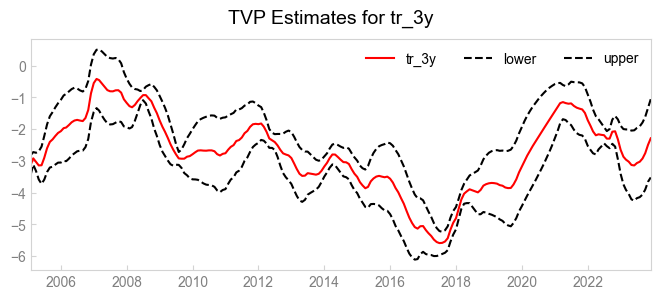

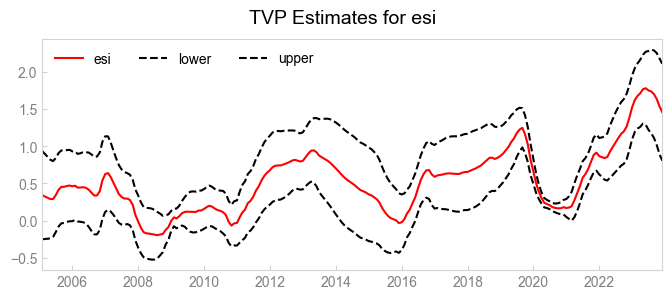

In [16]:
res.plot_tvp_estimates(figsize=(8,3), ncol=3)

res의 `plot_fitted_resi` 메서드를 이용해서 적합된 값과 잔차항 그림을 그릴 수 있다.

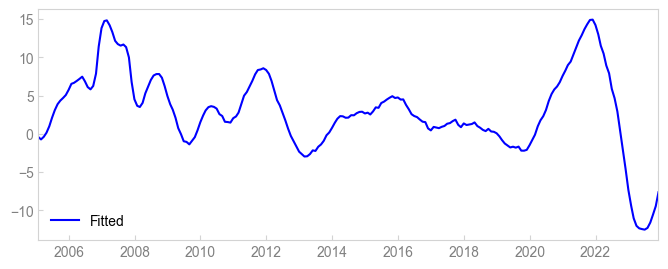

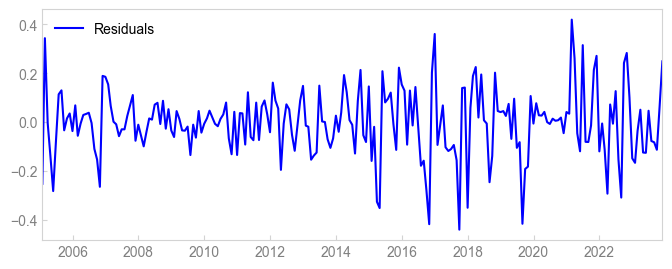

In [17]:
res.plot_fitted_resid(figsize=(8,3), title=False)

## TimeVaryingParameterModel 클래스로 모형 설정하고, 추정하기

모형 클래스 불러오기
- `tvp` 함수를 불러오는 방법외에 `TimeVaryingParameterModel` 클래스를 이용한 추정도 가능하다.

`ssm` 서브패키지에서 `TimeVaryingParameterModel` 클래스를 TVP로 불러온다.

In [18]:
from bok_da.ts.ssm import TimeVaryingParameterModel as TVP

In [19]:
y = 'hpi' # 종속변수: 전국 아파트매매가격지수 전년동기대비 증가율(%)
x = ['cpi', 'tr_3y', 'esi'] # 설명변수 (총3개): 소비자물가상승률(0), 국고채3년금리(1), 경제심리지수(2)

`TVP` 클래스를 이용해 model 객체를 생성하고, `fit` 메서드를 이용해 추정한다.

In [20]:
model = TVP(tvp_index = ['tr_3y', 'esi'])
res = model.fit(df[y], df[x], verbose=False)

10/10 cycle finished


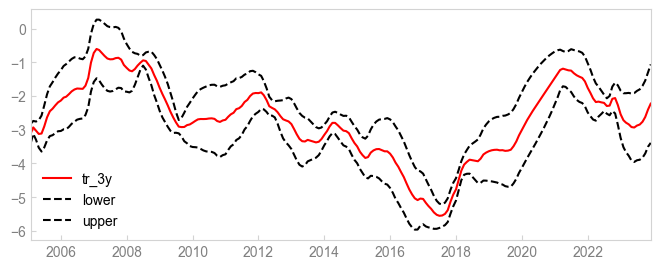

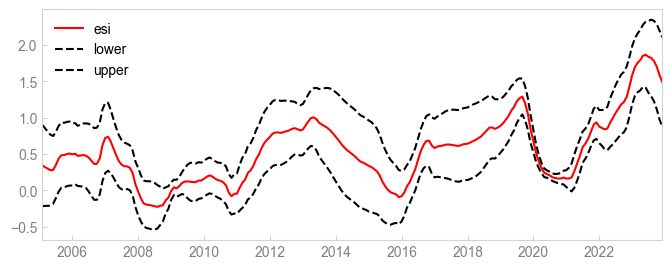

In [21]:
res.plot_tvp_estimates(figsize=(8,3), title=False)